In [ ]:
#pip install pandas_datareader
#pip install forex_python
#pip install price_wwp_homework_python_reboot_da

In [1]:
#%matplotlib inline
#import pandas as pd
#import numpy as np
#import matplotlib.pyplot as plt
#import os
#from pandas_datareader import data as pdr
#from bs4 import BeautifulSoup
#import requests
#from forex_python.converter import CurrencyRates
#import datetime
from price_wwp_homework_python_reboot_da import *
import matplotlib.pyplot as plt

# Задание 1.

Вы - менеджер по продажам в нефтехимической компании. Вы ведете несколько ключевых клиентов, которые закупают продукты вашей компании. Ваша компания запускает новый продукт - "Волшебный белый порошок" (ВБП), который по своим свойствам похож на тот, что уже есть на рынке. Ваши клиенты предпочитают формульный подход к ценообразованию. Вам нужно предложить клиентам формулу расчета цены на ВБП. В зависимости от объемов, которые покупают клиенты, им может быть предложена скидка.

### Дополнительные вводные:

Так как продукт Б новый, возможно стоит предложить дисконт от цены Продукта А. Продукт производиться из нефти. Один из известных способов производства предполагает что из 16 баррелей нефти сделают одну тонну ВБП, а затраты на производство в районе 400 евро.

In [2]:
# Из данных есть:
# Цены на продукт А, который уже есть на рынке Европы
# ----- октябрь 2018 - 1600 евро
# ----- ноябрь 2018 - 1550 евро
# ----- февраль 2019 - 1600 евро


# Котировки нефти, курс eur/usd
dbc = pd.read_excel('cur_oil.xlsx')

# Затраты на производство
PRODUCTION_COST = 400 # (EUR)

# Кол-во баррелей нефти для производства 1 тонны ВБП
BARRELS_TO_ONE_TON = 16

# Расходы на логистику
EU_LOGISTIC_COST_EUR = 30 # в Европу в евро
CN_LOGISTIC_COST_USD = 130 # в Китай в долларах

# * Справочная информация по клиентам(объемы, локации, комментарии) 
customers = {
    'Monty':{
        'location':'EU',
        'volumes':200,
        'comment':'moving_average'
    },
    
    'Triangle':{
        'location':'CN',
        'volumes': 30,
        'comment': 'monthly'
    },
    'Stone':{
        'location':'EU',
        'volumes': 150,
        'comment': 'moving_average'
    },
    'Poly':{
        'location':'EU',
        'volumes': 70,
        'comment': 'monthly'
    }
}
# Скидки
discounts = {'up to 100': 0.01, # 1%
             'up to 300': 0.05, # 5%
             '300 plus': 0.1}   #10%


### Что нужно сделать?

1. Проанализировать имеющиеся данные.
2. Определить базовую формулу цены на условиях FCA (цена на заводе). То есть как бы выглядела цена на исторических данных.
3. Отобразить на графике.
4. Сделать расчет возможной цены по формуле для каждого из клиентов на условиях DDP (цена с доставкой). Записать все в один эксель файл, на разных листах. Каждый лист - название клиента.
5. Предложить формулу цены каждому из клиентов на условиях DDP (цена с доставкой).
- Создать директорию «для клиентов» и в ней сложить  файлы с расчетами.
- Каждый клиент - отдельный файл (любой из docx, xlsx, pptx, pdf)  с именем клиента… 

### В результате должно быть 3 файла:
1. Ноутбук с расчетами и графиками. 
2. Скрипт, который делает расчет цены для каждого клиента в одном файле
2. Скрипт, который делает расчет цены для каждого клиента в отельном файле

# Допущения
1. Допустим, что у компании нет цели получать прибыль. Вводить коэффициент маржинальности не будем
2. Допустим, что PRODUCTION_COST - это затраты на производство одной тонны продукции
3. Допустим, что дисконт от цены товара А мы будем делать только тогда, когда цена товара А ниже нашего.
4. Допустим, что цена нефти в файле dbc указана в долларах
5. Допустим, что цена товара А нам известна только в течение 3 месяцев. И в эти месяцы цена оставалась неизменной каждый день

### Создадим формулу

У нас будет использована следующая формула:
***
oil * eur_rate * barrels_to_one_ton + production_cost - discount_on_price_a - discount_from_volume + logistic_cost,
***
где:

**oil** - цена барреля нефти, USD

**eur_rate** - курс евро/доллар, для пересчета в EUR

**barrels_to_one_ton** - количество баррелей нефти для производства одной тонны продукции, константа = 16

**production_cost** - затраты на производство в Евро, константа = 400

**discount_on_price_a** - скидка, если цена на продукт А оказалась меньше продукта ВБП

**discount_from_volume** - скидка для клиентов в зависимости от объемов

**logistic_cost** - стоимость логистики для региона клиента

### Реализуем функции

In [ ]:
class Information():
    def __init__(self):
        self.customers = {
            'Monty':{
                'location':'EU',
                'volumes':200,
                'comment':'moving_average'
            },
            'Triangle':{
                'location':'CN',
                'volumes': 30,
                'comment': 'monthly'
            },
            'Stone':{
                'location':'EU',
                'volumes': 150,
                'comment': 'moving_average'
            },
            'Poly':{
                'location':'EU',
                'volumes': 70,
                'comment': 'monthly'
            }
        }
        self.discounts = {'up to 100': 0.01,
             'up to 300': 0.05,
             '300 plus': 0.1}

        
class MyException(Exception):
    pass


def get_price_product_a(date):
    """
    Проверяет date и возвращает цену продукта А

    Parameters:
        date: День в формат datetime, timestamp
    
    Returns:
        Значение цены продукта А в день date

    Raises:
        MyException: когда date имеет некорректный формат
        
    """
    try:
        date = pd.to_datetime(date)
    except:
        raise MyException('Не распознан формат даты. Должен быть datetime, Timestamp')
        
    if pd.to_datetime(date).strftime('%Y-%m') == '2018-10':
        return 1600
    elif pd.to_datetime(date).strftime('%Y-%m') == '2018-11':
        return 1550
    elif pd.to_datetime(date).strftime('%Y-%m') == '2019-02':
        return 1600
    else:
        return 0


def get_price_with_discounts(date,
                             oil_price='auto',
                             barrels_to_one_ton=16, 
                             production_cost=400,
                             client='Noname',
                             eurusd_rate='auto',
                             discount_on_price_a=True,
                             discount_from_volume=True,
                             add_logistic_cost=True,
                             cn_logistic_cost_usd=130,
                             eu_logistic_cost_eur=30):
    """
    Получает цену на нефть, курс Евро.
    Рассчитывает цену на продукт ВБП с завода
    Рассчитывает скидку от объемов покупки продукта ВБП
    Рассчитывает скидку от цены продукта А
    Рассчитывает стоимость доставки клиенту

    Parameters:
        date: День в формат datetime, timestamp
        oil_price: Цена на нефть в USD. Если 'auto', цена будет взята из yahoo
        barrels_to_one_ton: Количество баррелей нефти для производства 1 тонны ВБП
        production_cost: Стоимость производства 1 тонны ВБП
        client: Название клиента
        eurusd_rate: курс евро к доллару. Если 'auto', курс будет взят с forex_python.converter.CurrencyRates
        discount_on_price_a: признак применения скидки от цена продукта А
        discount_from_volume: признак применения скидки от объемов покупки
        add_logistic_cost: признак применения цены логистики
        cn_logistic_cost_usd: цена доставки для Китая
        eu_logistic_cost_eur: цена доставки для Европы
    
    Returns:
        Цена на продукт ВБП

    Raises:
        MyException: когда date имеет некорректный формат
        
    """
    try:
        date = pd.to_datetime(date)
    except:
        raise MyException('Не распознан формат даты. Должен быть datetime, Timestamp')
        
    # получем цену на нефть
    if oil_price == 'auto':
        oil_price_usd = get_brent_rate(date)
    else:
        oil_price_usd = oil_price
    
    # получаем курс евро
    if eurusd_rate == 'auto':
        usd_eur_rate = get_currency_rate_eur(date, 'USD')
    else:
        usd_eur_rate = 1 / eurusd_rate
    
    # рассчитываем цену на ВБП
    try:
        price = ((oil_price_usd * usd_eur_rate) * barrels_to_one_ton) + production_cost
    except:
        price = 0
    
    # рассчитываем скидки
    if discount_on_price_a:
        discount_on_price_a = get_discount_on_price_a(price_a=get_price_product_a(date), 
                                                      price_b=price)
    else:
        discount_on_price_a = 0
        
    if discount_from_volume:
        discount_from_volume = (price * get_volume_discount(client))
    else:
        discount_from_volume = 0
        
    # рассчитываем затраты на доставку
    if add_logistic_cost:
        logistic_cost = get_logistic_cost(client, eu_logistic_cost_eur, cn_logistic_cost_usd)
    else:
        logistic_cost = 0
    return round(price - discount_on_price_a - discount_from_volume + logistic_cost, 2)


def get_logistic_cost(client='Noname', eu_logistic_cost_eur=30, cn_logistic_cost_usd=130):
    """
    Проверяет регион клиента и возвращает цену доставки

    Parameters:
        client: Название клиента
        cn_logistic_cost_usd: цена доставки для Китая
        eu_logistic_cost_eur: цена доставки для Европы
    
    Returns:
        Стоимость логистики продукта
        
    """
    info = Information()
    try:
        location = info.customers.get(client).get('location')
    except:
        print('Не найден клиент. Затраты на доставку = 0')
        return 0
    
    if location == 'EU':
        return eu_logistic_cost_eur
    elif location == 'CN':
        return cn_logistic_cost_usd
    else:
        print(f'Нет информации по доставке в регион {location}. Затраты на доставку = 0')
        return 0


def get_volume_discount(client='Noname'):
    """
    Возвращает значение скидки в зависимости от объемов покупок

    Parameters:
        client: Название клиента

    
    Returns:
        Значение скидки
        
    """
    info = Information()
    try:
        volume = info.customers.get(client).get('volumes')
    except:
        print(f'Не найдены объемы покупок для клиента {client}. Скидка равна 0')
        return 0
        
    if volume == 0:
        return 0
    elif volume >= 300: 
        return 0.1
    elif volume >= 100:
        return 0.05
    elif volume > 0:
        return 0.01
    else:
        return 0    


def get_discount_on_price_a(price_a, price_b):
    """
    Проверяет цены на продукты А и ВБП.
    Если продукт А дешевле, возвращает разницу

    Parameters:
        price_a: Цена на товар А
        price_b: Цена на товар ВБП
    
    Returns:
        Значение скидки
        
    """
    if price_a == 0:
        return 0
    elif price_b <= price_a:
        return 0
    elif price_b > price_a:
        return price_b - price_a
    else:
        return 0

    
def get_currency_rate_eur(date=datetime.datetime(2018,1,5), currency='USD'):
    """
    Возвращает отношение currency к Евро из библиотеки forex_python.converter.CurrencyRates

    Parameters:
        date: День в формат datetime, timestamp
        currency: Валюта, к которому необходимо получить курс Евро

    Returns:
        Отношение currency к Евро

    Raises:
        MyException: когда date имеет некорректный формат
        MyException: когда не найден курс для валюты за 5 дней
        
    """
    try:
        date = pd.to_datetime(date)
    except:
        raise MyException('Не распознан формат даты. Должен быть datetime, Timestamp')
    
    c = CurrencyRates()
    days_back = 0
    while days_back < 5: #5 попыток получить валюту в предыдущих днях
        try:
            rate = c.get_rate(currency, 'EUR', date - datetime.timedelta(days=days_back))
        except:
            days_back += 1
        else:
            return rate
    raise MyException(f'Не найден курс для {currency} на {date}')


def get_brent_rate(date):
    """
    Возвращает стоимость 1 барреля нефти из библиотеки pandas_datareader

    Parameters:
        date: День в формат datetime, timestamp
    
    Returns:
        Курс на баррель нефти Brent

    Raises:
        MyException: когда date имеет некорректный формат
        
    """
    try:
        date = pd.to_datetime(date)
    except:
        raise MyException('Не распознан формат даты. Должен быть datetime, Timestamp')
    data = pdr.DataReader('BZ=F', 'yahoo')
    days_back = 0
    while days_back < 5: #5 попыток получить стоимость нефти в предыдущих днях
        
        try:
            rate = data.loc[(date - datetime.timedelta(days=days_back)).strftime('%Y-%m-%d')].Open
        except:
            days_back += 1
        else:
            try:
                if len(rate) > 1: #DataReader иногда возвращает 2 строки с одной датой
                    return rate[0]
            except:
                return rate
    raise MyException(f'Не найден курс для нефти в {date}')


def get_rub_eur_rate(date):
    """
    Возвращает курс рубля к евро с сайта ЦБ РФ

    Parameters:
        date: День в формат DD.MM.YYYY

    Returns:
        Курс рубля к евро

    Raises:
        MyException: когда date имеет некорректный формат
        MyException: когда на сайте ЦБ РФ нет ставки в date
        
    """
    try:
        datetime.datetime.strptime(date, '%d.%m.%Y')
    except ValueError:
        raise ValueError("Некорректный формат даты, должен быть DD.MM.YYYY")
    
    url = f'http://www.cbr.ru/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01239&UniDbQuery.From={date}&UniDbQuery.To={date}'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    try:
        number = soup.find('table', {'class': 'data'}).text.find(date)
    except:
        raise MyException(f'На сайте ЦБ РФ нет ставки за день {date}')
    else:
        return float(soup.find('table', {'class': 'data'}).text[number+13:number+20].replace(',', '.'))


def script_for_1task_onefile():
    try:
        os.mkdir('Task1')
    except:
        pass
    clients_list = ['Monty', 'Triangle', 'Stone', 'Poly']
    filepath = os.path.join('Task1', 'DDP_price.xlsx')
    with pd.ExcelWriter(filepath) as writer: 
        for client in clients_list:
            dbc[f'DDP_price_{client}'] = dbc.apply(lambda x: 
                                                  get_price_with_discounts(date=x.Date,
                                                                           oil_price=x.OIL,
                                                                           eurusd_rate=x['EURUSD=X'],
                                                                           client=client,
                                                                           discount_on_price_a=True,
                                                                           discount_from_volume=True,
                                                                           add_logistic_cost=True,
                                                                           barrels_to_one_ton=BARRELS_TO_ONE_TON, 
                                                                           production_cost=PRODUCTION_COST,
                                                                           cn_logistic_cost_usd=CN_LOGISTIC_COST_USD,
                                                                           eu_logistic_cost_eur=EU_LOGISTIC_COST_EUR,), axis=1)

            dbc.loc[:, ['Date', 'EURUSD=X', 'OIL', f'DDP_price_{client}']].to_excel(writer, sheet_name=client)
            

def script_for_1task_manyfiles():
    try:
        os.mkdir(os.path.join('Task1', 'Clients'))
    except:
        pass

    clients_list = ['Monty', 'Triangle', 'Stone', 'Poly']

    for client in clients_list:
        filepath = os.path.join('Task1', 'Clients', f'{client}.xlsx')
        with pd.ExcelWriter(filepath) as writer: 
            dbc.loc[:, ['Date', 'EURUSD=X', 'OIL', f'DDP_price_{client}']].to_excel(writer, sheet_name='DDP_price')


def script_for_2task():
    client = input('Введите название компании (Monty, Triangle, Stone, Poly): ')
    date = input('Введите дату в формате YYYY-MM-DD: ')
    return get_price_with_discounts(date=datetime.datetime(int(date.split('-')[0]), 
                                                           int(date.split('-')[1]),
                                                           int(date.split('-')[2])),
                                     oil_price='auto',
                                     eurusd_rate='auto',
                                     client=client,
                                     discount_on_price_a=True,
                                     discount_from_volume=True,
                                     add_logistic_cost=True,
                                     barrels_to_one_ton=BARRELS_TO_ONE_TON, 
                                     production_cost=PRODUCTION_COST,
                                     cn_logistic_cost_usd=CN_LOGISTIC_COST_USD,
                                     eu_logistic_cost_eur=EU_LOGISTIC_COST_EUR)


def script_for_3task():
    date = input('Введите дату в формате YYYY-MM-DD: ')
    year = date.split('-')[0]
    month = date.split('-')[1]
    day = date.split('-')[2]
    price = get_price_with_discounts(date=datetime.datetime(int(year), 
                                                            int(month),
                                                            int(day)),
                                     oil_price='auto',
                                     eurusd_rate='auto',
                                     client='Noname',
                                     discount_on_price_a=True,
                                     discount_from_volume=False,
                                     add_logistic_cost=False,
                                     barrels_to_one_ton=BARRELS_TO_ONE_TON, 
                                     production_cost=PRODUCTION_COST,
                                     cn_logistic_cost_usd=CN_LOGISTIC_COST_USD,
                                     eu_logistic_cost_eur=EU_LOGISTIC_COST_EUR)

    rate = get_rub_eur_rate(f'{day}.{month}.{year}')
    print(f'Price is: {price} EUR or {round(price*rate, 2)} RUB')

### Рассчитаем цену FCA по архивным данным

In [3]:
%%time
dbc['FCA_price'] = dbc.apply(lambda x: 
                              get_price_with_discounts(date=x.Date,
                                                       oil_price=x.OIL,
                                                       eurusd_rate=x['EURUSD=X'],
                                                       client='Noname',
                                                       discount_on_price_a=False,
                                                       discount_from_volume=False,
                                                       add_logistic_cost=False,
                                                       barrels_to_one_ton=BARRELS_TO_ONE_TON, 
                                                       production_cost=PRODUCTION_COST,
                                                       cn_logistic_cost_usd=130,
                                                       eu_logistic_cost_eur=30,), axis=1)
dbc.head()

Wall time: 124 ms


,Date,EURUSD=X,OIL,FCA_price
0,2018-01-01,1.2005,NaN,NaN
1,2018-01-02,1.2012,59.15,1187.88
2,2018-01-03,1.2063,59.15,1184.55
3,2018-01-04,1.2010,59.15,1188.01
4,2018-01-05,1.2069,60.44,1201.26


### Нарисуем график цены с завода

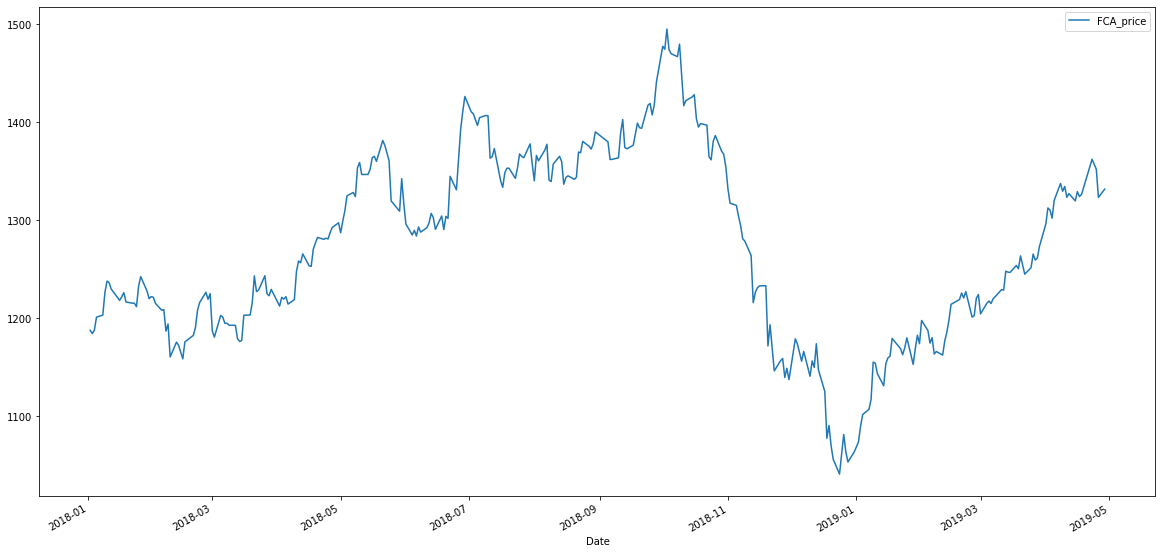

In [4]:
plt.figure(figsize=(20,10))
dbc.set_index('Date').FCA_price.dropna().plot(legend=True)
plt.show()

### Создадим один xlsx файл с расчетом для каждого клиента на отдельном листе в папке /Task1

In [5]:
try:
    os.mkdir('Task1')
except:
    pass
clients_list = ['Monty', 'Triangle', 'Stone', 'Poly']
filepath = os.path.join('Task1', 'DDP_price.xlsx')
with pd.ExcelWriter(filepath) as writer: 
    for client in clients_list:
        dbc[f'DDP_price_{client}'] = dbc.apply(lambda x: 
                                              get_price_with_discounts(date=x.Date,
                                                                       oil_price=x.OIL,
                                                                       eurusd_rate=x['EURUSD=X'],
                                                                       client=client,
                                                                       discount_on_price_a=True,
                                                                       discount_from_volume=True,
                                                                       add_logistic_cost=True,
                                                                       barrels_to_one_ton=BARRELS_TO_ONE_TON, 
                                                                       production_cost=PRODUCTION_COST,
                                                                       cn_logistic_cost_usd=CN_LOGISTIC_COST_USD,
                                                                       eu_logistic_cost_eur=EU_LOGISTIC_COST_EUR,), axis=1)
        
        dbc.loc[:, ['Date', 'EURUSD=X', 'OIL', f'DDP_price_{client}']].to_excel(writer, sheet_name=client)
dbc.head()

,Date,EURUSD=X,OIL,FCA_price,DDP_price_Monty,DDP_price_Triangle,DDP_price_Stone,DDP_price_Poly
0,2018-01-01,1.2005,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,1.2012,59.15,1187.88,1158.48,1306.00,1158.48,1206.00
2,2018-01-03,1.2063,59.15,1184.55,1155.32,1302.70,1155.32,1202.70
3,2018-01-04,1.2010,59.15,1188.01,1158.61,1306.13,1158.61,1206.13
4,2018-01-05,1.2069,60.44,1201.26,1171.20,1319.25,1171.20,1219.25


### Создадим xlsx файлы с расчетом для каждого клиента в папке /Task1/Clients

Используем уже ранее подготовленный датафрейм

In [6]:
try:
    os.mkdir(os.path.join('Task1', 'Clients'))
except:
    pass

clients_list = ['Monty', 'Triangle', 'Stone', 'Poly']

for client in clients_list:
    filepath = os.path.join('Task1', 'Clients', f'{client}.xlsx')
    with pd.ExcelWriter(filepath) as writer: 
        dbc.loc[:, ['Date', 'EURUSD=X', 'OIL', f'DDP_price_{client}']].to_excel(writer, sheet_name='DDP_price')

# Задание 2. Продолжение

Клиенты согласились на ваше предложение. 
Вам нужно сделать написать скрипт, с помощью которого можно автоматом рассчитывать цены для всех клиентов одновременно. 
Важный момент: данные для расчета скрипт должен подтягивать сам.

В результате должно быть 3 файла
1. Ноутбук с расчетами и графиками (чтобы данные подтягивались туда)
2. Скрипт, который делает расчет цены для клиента (чтобы данные подтягивались туда сами)

### Запустим скрипт 
Вызовем функцию get_price_with_discounts

На вход данной функции мы подаем лишь дату, на которую требуется рассчитать цену и название клиента.

Цена на нефть будет взята с yahoo из библиотеки pandas_datareader, курс валюты из библиотеки forex_python.
Информация клиентам и скидами занесена в класс Information()

In [7]:
script_for_2task()

Введите название компании (Monty, Triangle, Stone, Poly): Monty
Введите дату в формате YYYY-MM-DD: 2021-07-30


1378.93

# Задание 3. Back to Russia

К вам пришел новый клиент из России. Который использует продукт А и готов регулярно закупать ВБП для того, чтобы не быть привязанным к одному поставщику. Клиент готов забирать ВБП с завода самостоятельно.
1. На основе тех данных, которые уже есть предложите цену новому клиенту. 
2. Подготовьте скрипт, который будет использовать курс публикуемый на <a href='http://www.cbr.ru/currency_base/dynamics/'> сайте ЦБ РФ</a>.


### Запустим скрипт
Вызовем функцию get_price_with_discounts. Дополнительно запустим функцию get_rub_eur_rate, которая получит курс рубля к евро на заданную дату с сайта ЦБ РФ

In [8]:
script_for_3task()

Введите дату в формате YYYY-MM-DD: 2021-07-30
Price is: 1419.93 EUR or 123338.53 RUB


# Задание 4. Check it

* Подумайте, как можно проверить корректность работы алгоритма? 
* Какие возможны ошибки?
* Придумайте тесты для проверки возможных ошибок алгоритма
* Интергрируйте их в свои скрипты в виде исключений


### Добавлены

# Задание 5. Поделись с ближним

Вы решили пойти в отпуск на время вашего отсутствия вас будет заменять коллега. Он будет заниматься рассчетом цен для клиентов. Чтобы ему было проще вам нужно завернуть ваши скрипты в модуль, который будет запускать у себя коллега.

* Создайте модуль, который можно запускать в ноутбуке подкладывая в ту же директорию
* Хорошенько задокументируйте ВСЁ, но помните о PEP8

In [ ]:
from price_wwp_homework_python_reboot_da import *

# Задание 6. Поделись пакетом

Ваши коллеги узнали, что вы быстро рассчитываете цены для формульных контрактов, и решили использовать такую же практику для своих продуктов и клиентов. Вам нужно создать пакет, чтобы его было проще устанавливать и использовать.

* Создайте отдельный пакет, который можно устанавливать с помощью pip 
* В пакете должны быть реализованы функции для рассчета цен по формульным контрактам
* Выложите пакет в репозиторий

In [ ]:
from price_wwp_homework_python_reboot_da import *
import matplotlib.pyplot as plt